In [1]:
import astropy.io.fits as fits
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
os.chdir('/home/b7009348/projects/WGL_Project')

In [14]:
with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hsu:
    print(np.size(hsu[1].data))

17865244


# Response Matrix
- 4 elements, must add selection bias response

In [2]:
with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    R11 = data['R11'] # e1-e1
    R12 = data['R12'] # e1-e2
    R21 = data['R21'] # e2-e1
    R22 = data['R22'] # e2-e2

R = np.vstack((R11,R12,R21,R22))

del R11, R12, R21, R22, data

# Selection Response

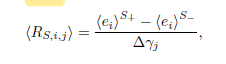

In [6]:
Image.open('des-y1-matched-catalogue/selection_response_eqn.png')

- Need to measure response of estimator to the selection
- Selection is a cut on object IDs so take matched catalogue, so need to reconstruct equation:

$<R_{S,i,j}> = \frac{<e_{i}^{+}>^{IDs}-<e_{i}^{-}>^{IDs}}{\Delta\gamma_{j}}$

- Select on IDs, mean of ellipticies of positively and negatively sheared images

Calculation of $R_{S,i,j}$

In [3]:
del_g = 2 * 0.01

with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    e1_1p = data['e1_1p'] # + g1=0.01
    e1_1m = data['e1_1m'] # + g1=-0.01
    e1_2p = data['e1_2p'] # + g2=0.01
    e1_2m = data['e1_2m'] # + g2=-0.01

    e2_1p = data['e2_1p'] # + g1=0.01
    e2_1m = data['e2_1m'] # + g1=-0.01
    e2_2p = data['e2_2p'] # + g2=0.01
    e2_2m = data['e2_2m'] # + g2=-0.01
    
del data
    
Rs_11 = (e1_1p-e1_1m)/del_g # component e1 sheared by g1=+/-0.01
Rs_12 = (e1_2p-e1_2m)/del_g # component e1 sheared by g2=+/-0.01
Rs_21 = (e2_1p-e2_1m)/del_g # component e2 sheared by g1=+/-0.01
Rs_22 = (e2_2p-e2_2m)/del_g # component e2 sheared by g2=+/-0.01

del e1_1p, e1_1m, e1_2p, e1_2m, e2_1p, e2_1m, e2_2p, e2_2m

Rs = np.vstack([Rs_11, Rs_12, Rs_21, Rs_22])

del Rs_11, Rs_12, Rs_21, Rs_22

In [4]:
print('Selection Response: %.16f Shear Response: %.16f '%(np.mean(Rs), np.mean(R)))

Selection Response: 0.3566336398133704 Shear Response: 0.3566336398133704 


In [8]:
1.0/(np.mean(Rs) + np.mean(R))

1.4019989820972987

# Tangential Shear 
(count-shear correlation + response correction)

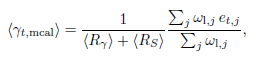

In [23]:
Image.open('des-y1-matched-catalogue/mcal_gammat_eqn.png')

Ry and Rs have no significant variation with $\theta$ so can use constant value

In [9]:
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)
    
with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1_m = data['e1']
    e2_m = data['e2']
    
del data

cat_s_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1_m, g2=e2_m, patch_centers=cat_l.patch_centers)

with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    ra_r = data['RA']
    dec_r = data['dec']
    
del data
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

print('Catalogues created, starting correlation calculation...')

nbins=20
theta_min=2.5
theta_max=250

mcal_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
mcal_ng.process(cat_l, cat_s_mcal)

mcal_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_rg.process(cat_r, cat_s_mcal)

print('Correlation calculation complete.')

del cat_s_mcal

Catalogues created, starting correlation calculation...
Correlation calculation complete.


In [10]:
mcal_xi_l = mcal_ng.xi
mcal_xi_r = mcal_rg.xi

mcal_Gammat = 1.0/np.mean(R) * (mcal_xi_l - mcal_xi_r)

mcal_theta = np.exp(mcal_ng.meanlogr)

del e1_m, e2_m, R, Rs

In [11]:
with fits.open('DES-data/y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data

e1_i = data['e1'] - data['c1']
e2_i = data['e2'] - data['c2']
w = data['weight']
sens= data['m'] + 1.0
    
del data

print('Data loaded...')

cat_s_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1_i, g2=e2_i, w=w, patch_centers=cat_l.patch_centers)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)

print('Catalogues created, calculating correlation...')

im3_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
im3_ng.process(cat_l, cat_s_im3)
nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
nk.process(cat_l, cat_k)

im3_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
im3_rg.process(cat_r, cat_s_im3)
rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
rk.process(cat_r, cat_k)

print('Correlation calculation complete')

Data loaded...
Catalogues created, calculating correlation...
Correlation calculation complete


In [12]:
im3_xi_l = im3_ng.xi
sens_l = nk.xi
im3_xi_r = im3_rg.xi
sens_r = rk.xi

im3_Gammat = im3_xi_l/sens_l - im3_xi_r/sens_r

im3_theta = np.exp(im3_ng.meanlogr)

del e1_i, e2_i, sens, w

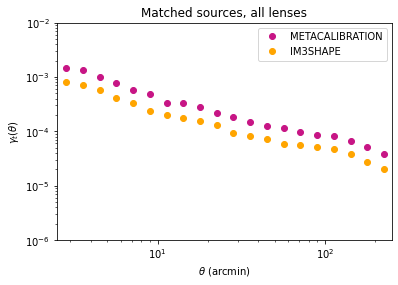

In [13]:
plt.plot(mcal_theta, mcal_Gammat, linewidth=0, marker='o', color='mediumvioletred')
plt.plot(im3_theta, im3_Gammat, linewidth=0, marker='o', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.title('Matched sources, all lenses')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.legend(['METACALIBRATION', 'IM3SHAPE'])
plt.savefig('des-y1-matched-catalogue/matched-sources_all-lenses.png', dpi=300)

In [22]:
ratio = mcal_Gammat/im3_Gammat
perc = (ratio-1.0)*100
print(np.mean(perc))

80.55663076012341


In [23]:
mcal_Gammat - im3_Gammat

array([5.77688439e-04, 5.41921018e-04, 4.75598883e-04, 3.49924947e-04,
       2.68570384e-04, 2.10131476e-04, 1.45679694e-04, 1.36893524e-04,
       1.21386815e-04, 8.51653614e-05, 7.86339195e-05, 7.46470442e-05,
       5.98888786e-05, 4.44427976e-05, 4.89449111e-05, 3.66690958e-05,
       3.80578131e-05, 2.52427885e-05, 2.09652667e-05, 2.26082993e-05])